In [23]:
import mdtraj as md
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KMeans
from msmbuilder.featurizer import RMSDFeaturizer

In [12]:

ref='/home/dongdong/SCR/jxy/R1002-D2.run02/iter.000000/00.enhcMD/000/pdb/conf0.pdb'
traj=md.load(ref)
topology = traj.topology
ca=topology.select('name CA')

In [13]:
ca

array([  4,  20,  31,  46,  67,  77, 101, 112, 126, 145, 159, 178, 202,
       217, 229, 251, 262, 276, 290, 301, 315, 334, 353, 367, 383, 404,
       416, 431, 453, 464, 488, 504, 519, 535, 554, 571, 587, 599, 606,
       618, 642, 653, 675, 691, 707, 728, 740, 752, 774, 793, 800, 821,
       837, 857, 871, 892, 912, 931, 942])

In [5]:
xyz = dataset('/home/dongdong/SCR/jxy/R1002-D2.run02/MSM/trj/*.xtc',topology=ref)

In [15]:
featurizer=RMSDFeaturizer(reference_traj=traj,atom_indices = ca)

In [16]:
rmsd=featurizer.fit_transform(xyz)

In [24]:
clusterer = KMeans(n_clusters=2000, random_state=42)

In [26]:
clustered_trajs=clusterer.fit(rmsd)

In [30]:
len(clustered_trajs.cluster_centers_)

2000

In [47]:
cd /home/dongdong/SCR/jxy/R1002-D2.run02/traj

/scratch/gpfs/dongdong/jxy/R1002-D2.run02/traj


In [105]:
import gromacs as gmx
import numpy as np
import os
import pathlib
os.chdir('/home/dongdong/SCR/jxy/R1002-D2.run02/traj/')
for en in range(0,8):

    ndx=gmx.fileformats.NDX()
    ndx.read('clusters%d.ndx' %en)
    
    cluster_num=len(ndx)
    total_num=cluster_num*2
    res_num=total_num-cluster_num
    
    selected_ndx=[]
    for val in ndx.values():
        selected_ndx.append(val[int(len(val)/2)])
        #selected_ndx.append(val[-1])
        temp_num=int(res_num*(len(val)/21021))
        for t in range(temp_num):
            selected_ndx.append(val[int(len(val)/temp_num)*(t)])
    sorted_ndx=sorted(selected_ndx)
    outdir='selected_pdb3/walker%03d' %en
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    np.savetxt('%s/index.ndx' %outdir,sorted_ndx, fmt='%d')
    for ss in sorted_ndx:
        itera=(ss-1)//1001
        struc_idx=np.mod((ss-1),1001)
        struc_name='/home/dongdong/SCR/jxy/R1002-D2.run02/iter.%06d/00.enhcMD/%03d/pdb/conf%d.pdb' %(itera,en,struc_idx)
        score_name='/home/dongdong/SCR/jxy/R1002-D2.run02/iter.%06d/00.enhcMD/%03d/pdb/conf%d.sc' %(itera,en,struc_idx)
        os.system('cp %s %s/conf%d.pdb' %(struc_name, outdir, ss))
        os.system('cp %s %s/conf%d.sc' %(score_name, outdir, ss))

68.22
75.85
71.19
71.19
71.19
68.64
73.31
76.27


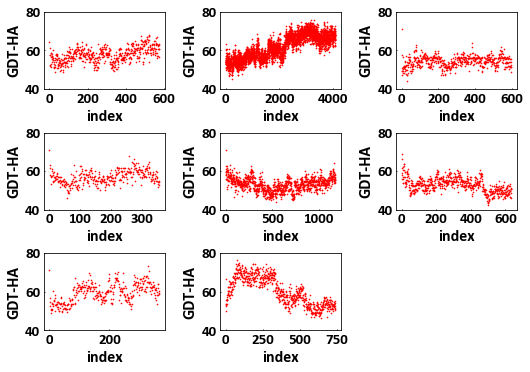

all number: 8551


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
os.chdir('/home/dongdong/SCR/jxy/R1002-D2.run02/traj/selected_pdb2')
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

71.19
74.58
71.19
71.19
71.19
71.19
71.19
76.27


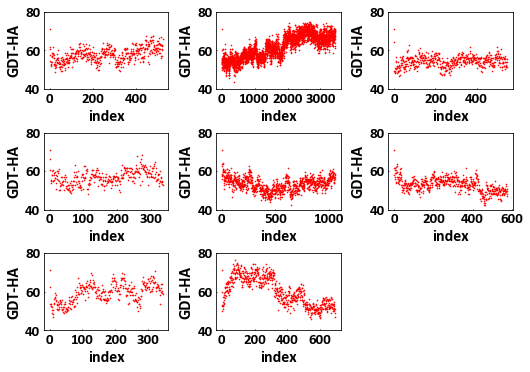

67.37
74.58
71.19
71.19
71.19
63.56
71.19
76.27


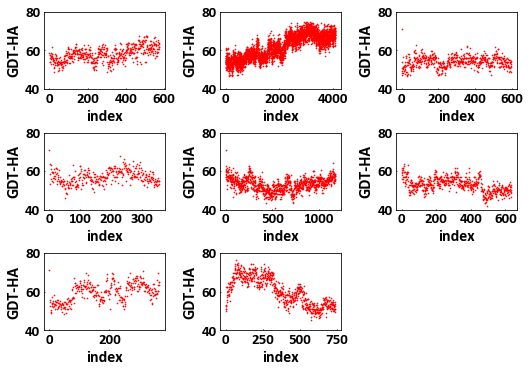

In [2]:
import gromacs as gmx
import numpy as np
import os
import pathlib
pdb_dir='R0974s1.run03'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/' %pdb_dir)
for en in range(0,8):

    ndx=gmx.fileformats.NDX()
    ndx.read('clusters%d.ndx' %en)
    
    cluster_num=len(ndx)
    total_num=cluster_num*2
    res_num=total_num-cluster_num
    
    selected_ndx=[]
    for val in ndx.values():
        selected_ndx.append(val[int(len(val)/2)])
        #selected_ndx.append(val[-1])
        temp_num=int(res_num*(len(val)/21021))
        for t in range(temp_num):
            selected_ndx.append(val[int(len(val)/temp_num)*(t)])
    sorted_ndx=sorted(selected_ndx)
    outdir='selected_pdb/walker%03d' %en
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    np.savetxt('%s/index.ndx' %outdir,sorted_ndx, fmt='%d')
    for ss in sorted_ndx:
        itera=(ss-1)//1001
        struc_idx=np.mod((ss-1),1001)
        struc_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.pdb' %(pdb_dir,itera,en,struc_idx)
        score_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.sc' %(pdb_dir,itera,en,struc_idx)
        os.system('cp %s %s/conf%d.pdb' %(struc_name, outdir, ss))
        os.system('cp %s %s/conf%d.sc' %(score_name, outdir, ss))

NOTE: Some configuration directories are not set up yet: 
	/home/dongdong/.gromacswrapper
	/home/dongdong/.gromacswrapper/qscripts
	/home/dongdong/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0974s1.run03'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/R0974s1_selected_pdb' %pdb_dir)
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        if float(HA)>0.9:
            print(i)
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

85.87
81.88
86.96
82.61
6257.0
92.75
89.49
89.49
82.25


In [5]:
import gromacs as gmx
import numpy as np
import os
import pathlib
pdb_dir='R0986s2.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/' %pdb_dir)
for en in range(0,8):

    ndx=gmx.fileformats.NDX()
    ndx.read('clusters%d.ndx' %en)
    
    cluster_num=len(ndx)
    total_num=cluster_num*2
    res_num=0
    
    selected_ndx=[]
    for val in ndx.values():
        selected_ndx.append(val[int(len(val)/2)])
        #selected_ndx.append(val[-1])
        temp_num=int(res_num*(len(val)/21021))
        for t in range(temp_num):
            selected_ndx.append(val[int(len(val)/temp_num)*(t)])
    sorted_ndx=sorted(selected_ndx)
    outdir='selected_pdb0/walker%03d' %en
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    np.savetxt('%s/index.ndx' %outdir,sorted_ndx, fmt='%d')
    for ss in sorted_ndx:
        itera=(ss-1)//1001
        struc_idx=np.mod((ss-1),1001)
        struc_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.pdb' %(pdb_dir,itera,en,struc_idx)
        score_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.sc' %(pdb_dir,itera,en,struc_idx)
        os.system('cp %s %s/conf%d.pdb' %(struc_name, outdir, ss))
        os.system('cp %s %s/conf%d.sc' %(score_name, outdir, ss))

58.06
55.32
56.77
54.03
54.52
56.94
62.1
53.55


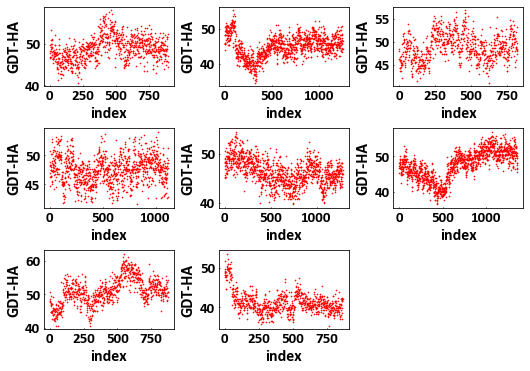

all number: 8469


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0986s2.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/selected_pdb' %pdb_dir)
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

In [7]:
import gromacs as gmx
import numpy as np
import os
import pathlib
pdb_dir='R0981-D5.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/' %pdb_dir)
for en in range(0,8):

    ndx=gmx.fileformats.NDX()
    ndx.read('clusters%d.ndx' %en)
    
    cluster_num=len(ndx)
    if cluster_num < 1000:
        res_num=500
    elif cluster_num >= 1000:
        res_num=300
    
    selected_ndx=[]
    for val in ndx.values():
        selected_ndx.append(val[int(len(val)/2)])
        #selected_ndx.append(val[-1])
        temp_num=int(res_num*(len(val)/21021))
        for t in range(temp_num):
            selected_ndx.append(val[int(len(val)/temp_num)*(t)])
    sorted_ndx=sorted(selected_ndx)
    outdir='selected_pdb/walker%03d' %en
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    np.savetxt('%s/index.ndx' %outdir,sorted_ndx, fmt='%d')
    for ss in sorted_ndx:
        itera=(ss-1)//1001
        struc_idx=np.mod((ss-1),1001)
        struc_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.pdb' %(pdb_dir,itera,en,struc_idx)
        score_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.sc' %(pdb_dir,itera,en,struc_idx)
        os.system('cp %s %s/conf%d.pdb' %(struc_name, outdir, ss))
        os.system('cp %s %s/conf%d.sc' %(score_name, outdir, ss))

41.54
41.54
41.54
41.54
41.54
41.93
41.54
39.76


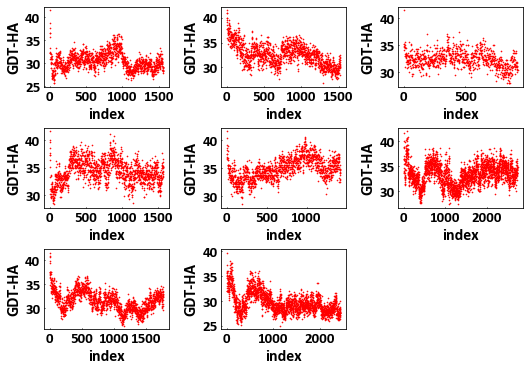

all number: 13957


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0981-D5.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/selected_pdb' %pdb_dir)
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

In [3]:
import gromacs as gmx
import numpy as np
import os
import pathlib
pdb_dir='R0986s1.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/' %pdb_dir)
for en in range(0,8):

    ndx=gmx.fileformats.NDX()
    ndx.read('clusters%d.ndx' %en)
    
    cluster_num=len(ndx)
    if cluster_num < 800:
        res_num=1200-cluster_num
    elif cluster_num >= 800 and cluster_num <= 1000:
        res_num=400
    elif cluster_num >= 1000:
        res_num=300
    
    selected_ndx=[]
    for val in ndx.values():
        selected_ndx.append(val[int(len(val)/2)])
        #selected_ndx.append(val[-1])
        temp_num=int(res_num*(len(val)/21021))
        for t in range(temp_num):
            selected_ndx.append(val[int(len(val)/temp_num)*(t)])
    sorted_ndx=sorted(selected_ndx)
    outdir='selected_pdb/walker%03d' %en
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    np.savetxt('%s/index.ndx' %outdir,sorted_ndx, fmt='%d')
    for ss in sorted_ndx:
        itera=(ss-1)//1001
        struc_idx=np.mod((ss-1),1001)
        struc_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.pdb' %(pdb_dir,itera,en,struc_idx)
        score_name='/home/dongdong/SCR/jxy/%s/iter.%06d/00.enhcMD/%03d/pdb/conf%d.sc' %(pdb_dir,itera,en,struc_idx)
        os.system('cp %s %s/conf%d.pdb' %(struc_name, outdir, ss))
        os.system('cp %s %s/conf%d.sc' %(score_name, outdir, ss))

77.17
60.6
61.41
68.48
72.01
54.62
68.48
74.18


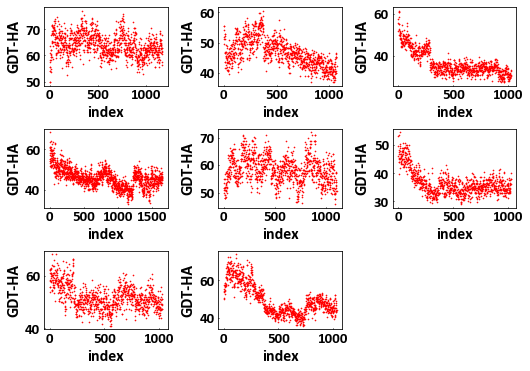

all number: 9097


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0986s1.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/selected_pdb' %pdb_dir)
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

39.4
43.67
38.13
40.98
38.13
40.66
42.09
38.29


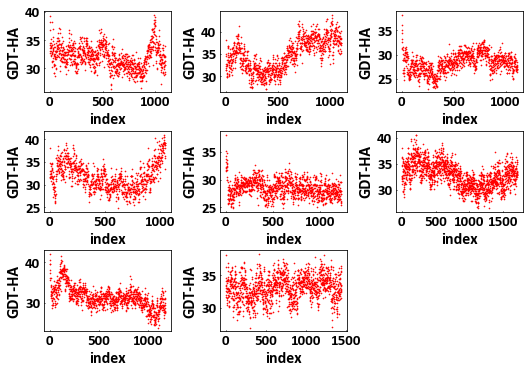

all number: 9929


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0957s2.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/selected_pdb' %pdb_dir)
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

61.69
55.84
62.99
60.39
60.06
54.22
53.57
53.9


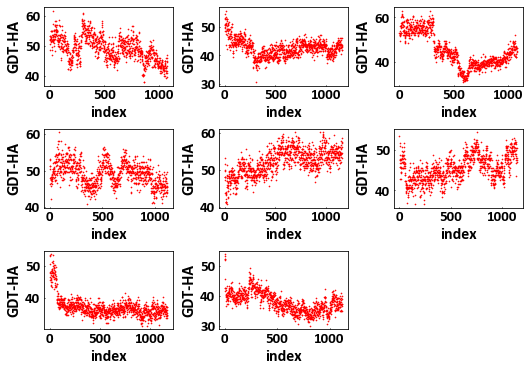

all number: 9036


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0958.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/selected_pdb' %pdb_dir)
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

58.87
55.32
57.74
54.19
54.52
56.94
62.1
53.55


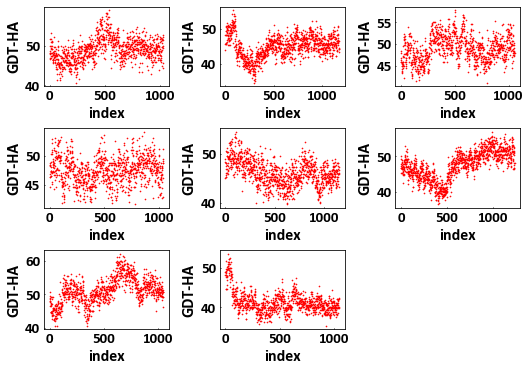

all number: 8778


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0986s2.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

70.34
75.85
71.19
71.19
71.19
68.64
73.73
76.69


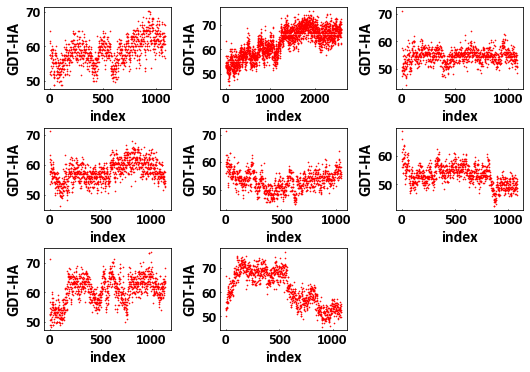

all number: 10234


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R1002-D2.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

53.84
58.07
55.03
56.08
53.57
53.84
55.29
54.37


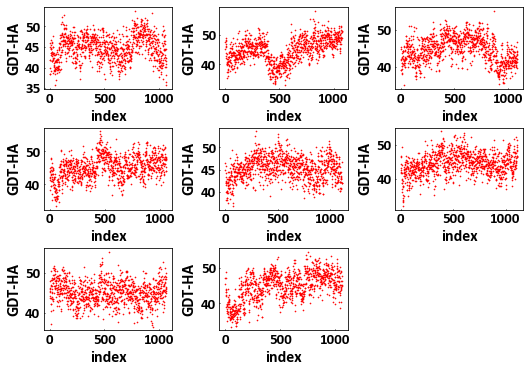

all number: 8651


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0959.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

46.9
46.9
46.9
46.9
46.9
46.9
46.9
46.9


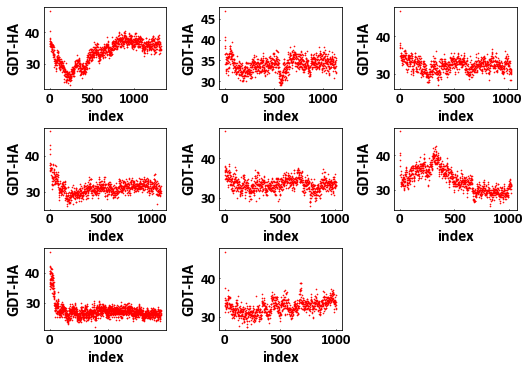

all number: 9508


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0949.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

57.83
55.43
58.26
57.83
58.48
61.96
54.78
55.87


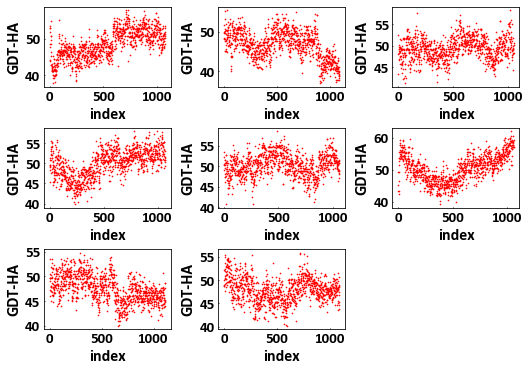

all number: 8616


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0968s2.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

61.67
61.04
60.0
65.83
65.83
73.33
75.0
60.21


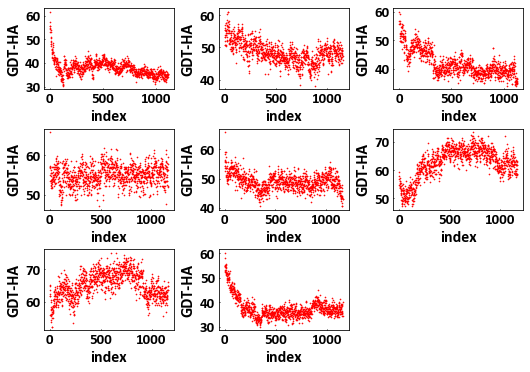

all number: 9199


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0976-D1.run02'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

63.56
61.72
61.72
62.71
65.25
60.029999999999994
61.019999999999996
60.029999999999994


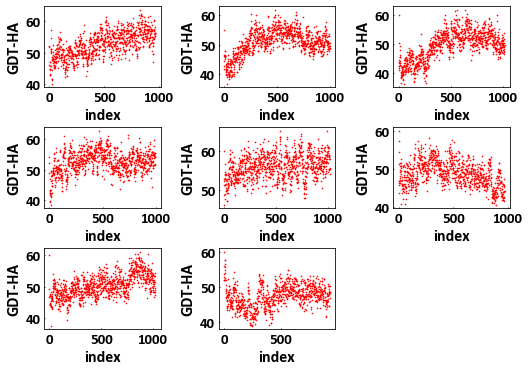

all number: 7916


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0962.run03'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

55.08
51.06
51.910000000000004
50.0
51.690000000000005
57.42
57.63
53.18000000000001


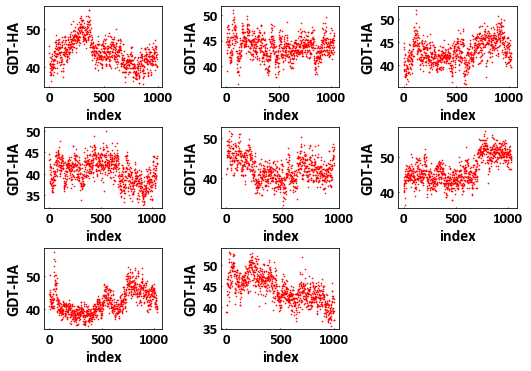

all number: 8118


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0968s1.run03'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)

66.73
64.52
66.73
60.28
62.3
64.72
66.73
66.73


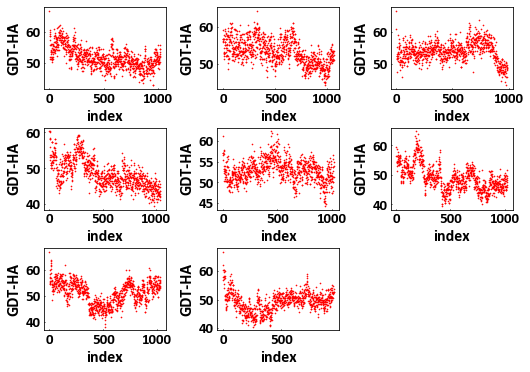

all number: 8138


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(8,7))
num_walkers=8
pdb_dir='R0976-D2.run03'
os.chdir('/home/dongdong/SCR/jxy/%s/traj/%s_selected_pdb' %(pdb_dir,pdb_dir.split('.')[0]))
allnum=0
for en in range(num_walkers):
    allrmsd=[]
    allTM=[]
    allTS=[]
    allHA=[]
    dirname='walker%03d/' %en
    idx=np.loadtxt(dirname+'/index.ndx')
    for i in idx:
        allnum+=1
        filename=dirname+'conf%d.sc' %i
        rf=open(filename,'r')
        lines=rf.readlines()
        rmsd=lines[14].strip().split()[-1]
        TM=lines[16].strip().split()[2]
        TS=lines[18].strip().split()[1]
        HA=lines[19].strip().split()[1]
        allrmsd.append(float(rmsd))
        allTM.append(float(TM))
        allTS.append(float(TS))
        allHA.append(float(HA)*100)

    sub = fig.add_subplot(int(num_walkers)/2,3,en+1)
    sub.scatter(np.array(range(len(allHA))),allHA,s=0.4,alpha=1,c='red')
    print(np.max(allHA))
    sub.set_ylabel(r'GDT-HA',fontproperties=font_prop)
    sub.set_xlabel(r'index',fontproperties=font_prop)
    #sub.plot(np.array(range(len(allrmsd)))/1000.0*2,[0.15]*len(allrmsd),lw=0.9,c='black')
    sub.tick_params(direction="in", length=1)
    #plt.ylim(40,80)
    #plt.xlim(25,55)
    #sub.set_yticks(np.linspace(0,0.8,5))
    #plt.xlim(25,55)
    #ax.set_yticks(np.linspace(0,2,5))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(15)
#
plt.tight_layout(pad=3, w_pad=0.8, h_pad=0.4)
plt.savefig('GDTHA.png',dpi=600,bbox_inches='tight')
plt.show()

print('all number: %d' %allnum)